## Prediction Model with Prophet

In [11]:
# import common 
import sys
sys.path.append('../common/')
from functions import get_view_counts

# import libraries
import pandas as pd
import numpy as np

from pymongo import MongoClient
from fbprophet import Prophet

### Make a dataframe from mongodb

**Collections**
* video_detail : contains title, url, published date, video_id of video
* view_count : contains # of views, comments, likes

In [5]:
# connect mongodb through ssh tunnel
connection = MongoClient(port=47017)
db = connection['youtube_scrap']

### Load video detail to dataframe

In [6]:
# load from mongodb
video_coll = db['video_detail']
video_cur = video_coll.find({})
videos = [video for video in video_cur]

In [52]:
# select a video
video = videos[9]

In [53]:
# get view_counts for selected video
df = get_view_counts(db, video['video_id'])
df.head()

,_id,comment_count,like_count,timestamp,title,video_id,view_count
0,5d13b7a19ec6103a9817d75e,4495,183308,2019-06-26 18:21:16.925,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5505871
1,5d13c37b9ec6103a9817d89b,4497,183393,2019-06-26 19:11:51.844,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5509723
2,5d13c4779ec6103a9817d8af,4497,183397,2019-06-26 19:16:03.135,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5510424
3,5d13cdb89ec6103a9817d993,4498,183476,2019-06-26 19:55:32.016,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5514608
4,5d13d3ad9ec6103a9817da31,4501,183530,2019-06-26 20:20:57.911,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5517267


### Make a prediction with Prophet

In [54]:
# initialize Prophet model
m = Prophet()

In [55]:
# prepare dataframe for Prophet
est_df = df[['timestamp', 'view_count']]
est_df.columns = ['ds', 'y']
est_df.head()

,ds,y
0,2019-06-26 18:21:16.925,5505871
1,2019-06-26 19:11:51.844,5509723
2,2019-06-26 19:16:03.135,5510424
3,2019-06-26 19:55:32.016,5514608
4,2019-06-26 20:20:57.911,5517267


In [56]:
# fit to model
m.fit(est_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/Users/teo/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [57]:
# make dataframe for estimatin after 3 days 
future = m.make_future_dataframe(periods=3)
future.tail()

,ds
274,2019-07-02 18:45:13.221
275,2019-07-02 19:08:34.862
276,2019-07-03 19:08:34.862
277,2019-07-04 19:08:34.862
278,2019-07-05 19:08:34.862


In [58]:
# perform predict 
forecast = m.predict(future)

In [66]:
# extracting some data
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
274,2019-07-02 18:45:13.221,6.059606e+06,6.058804e+06,6.060433e+06
275,2019-07-02 19:08:34.862,6.060940e+06,6.060086e+06,6.061782e+06
276,2019-07-03 19:08:34.862,6.135711e+06,6.117751e+06,6.152986e+06
277,2019-07-04 19:08:34.862,6.210482e+06,6.155276e+06,6.262306e+06
278,2019-07-05 19:08:34.862,6.285253e+06,6.183072e+06,6.379929e+06


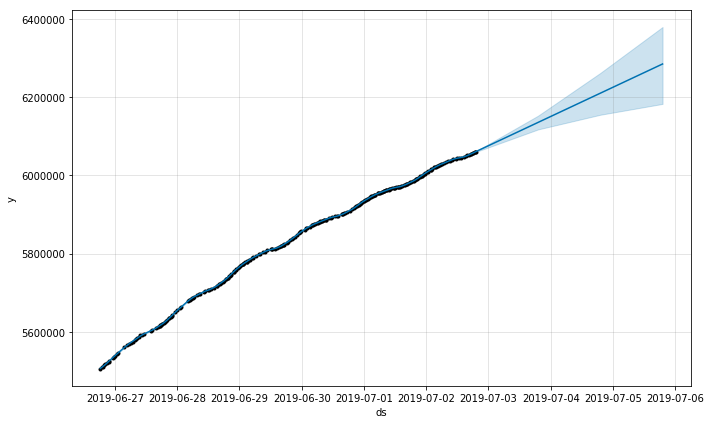

In [60]:
# Draw a chart with forecast
fig1 = m.plot(forecast)

### Accuracy of estimation